In [1]:
from datascience import *
import numpy as np

import matplotlib.pyplot as plots
from mpl_toolkits.mplot3d import Axes3D
plots.style.use('fivethirtyeight')
%matplotlib inline

In [3]:
scores = Table.read_table('https://raw.githubusercontent.com/oanapy/Data_science_BerkeleyX/master/scores.csv')
scores.show(5)

Midterm 1,Midterm 2,Mentored
28,20,False
28.5,35,False
23.5,13.5,False
24.5,22.5,True
28.5,35.5,True


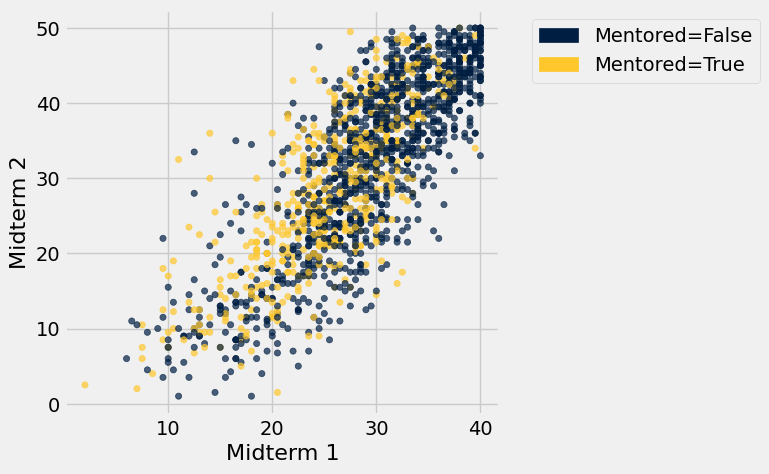

In [4]:
scores.scatter('Midterm 1', 'Midterm 2', group='Mentored')

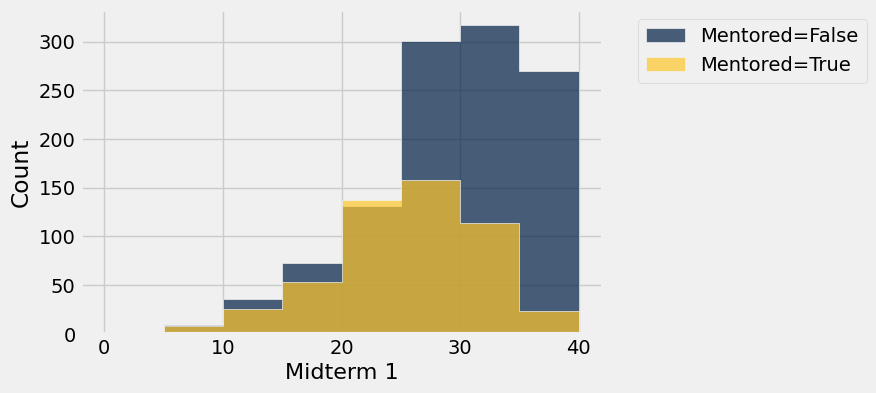

In [5]:
scores.hist('Midterm 1', group='Mentored', bins=np.arange(0, 41, 5), normed=False)

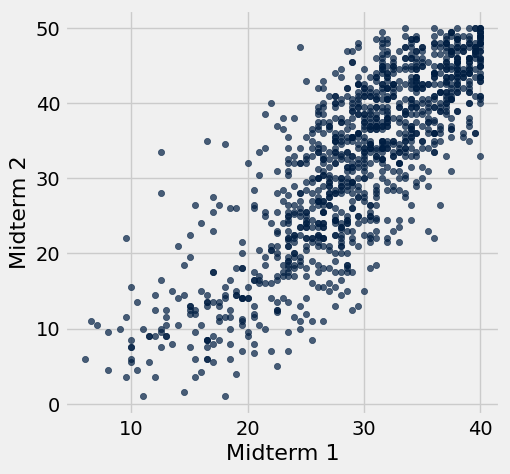

In [6]:
scores.where('Mentored', False).scatter('Midterm 1', 'Midterm 2')

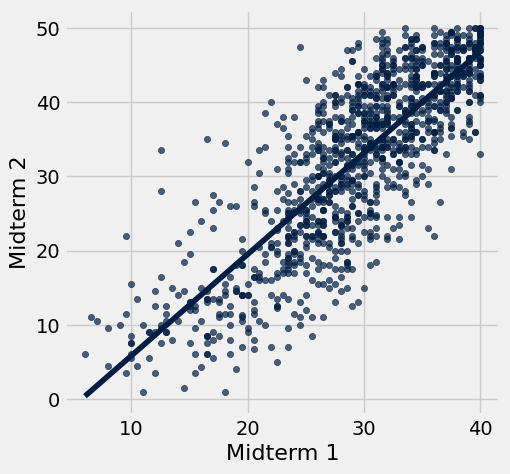

In [7]:
control = scores.where('Mentored', False)
control.scatter('Midterm 1', 'Midterm 2', fit_line=True)

In [8]:
def standard_units(any_numbers):
    """Convert any array of numbers to standard units."""
    return (any_numbers - np.mean(any_numbers)) / np.std(any_numbers)

# Below, t is a table; x and y are column indices or labels.

def correlation(t, x, y):
    """The correlation coefficient (r) of two variables."""
    return np.mean(standard_units(t.column(x)) * standard_units(t.column(y)))

def slope(t, x, y):
    """The slope of the regression line (original units)."""
    r = correlation(t, x, y)
    return r * np.std(t.column(y)) / np.std(t.column(x))

def intercept(t, x, y):
    """The intercept of the regression line (original units)."""
    return np.mean(t.column(y)) - slope(t, x, y) * np.mean(t.column(x))

def fitted_values(t, x, y):
    """The fitted values along the regression line."""
    a = slope(t, x, y)
    b = intercept(t, x, y)
    return a * t.column(x) + b

def residuals(t, x, y):
    return t.column(y) - fitted_values(t, x, y)

def plot_residuals(t, x, y):
    with_residuals = t.with_columns(
        'Fitted', fitted_values(t, x, y),
        'Residual', residuals(t, x, y)
    )
    with_residuals.select(x, y, 'Fitted').scatter(0)
    with_residuals.scatter(x, 'Residual')

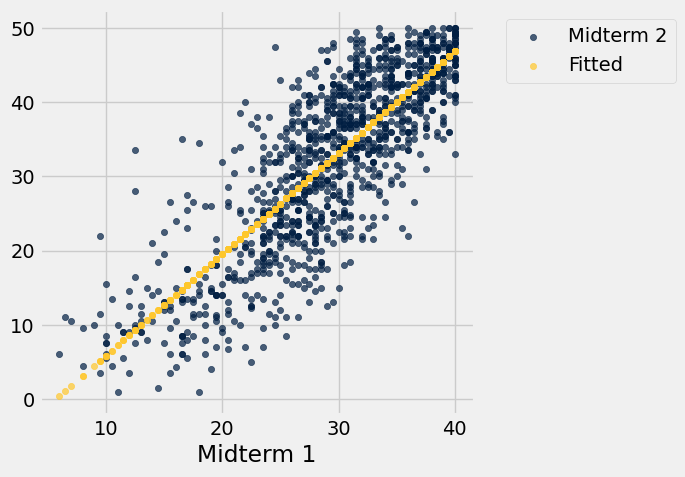

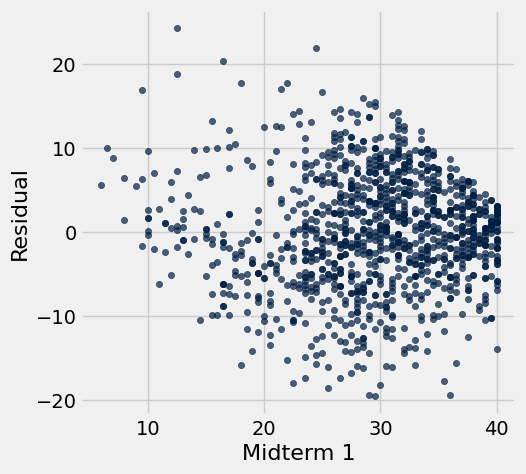

In [9]:
plot_residuals(control, 'Midterm 1', 'Midterm 2')

In [12]:
examples = scores.where('Mentored', False)

def predict_mt2(mt1):
    near = examples.where('Midterm 1', are.between_or_equal_to(mt1-2, mt1+2))
    return near.column('Midterm 2').mean()

predict_mt2(30)

34.11057692307692

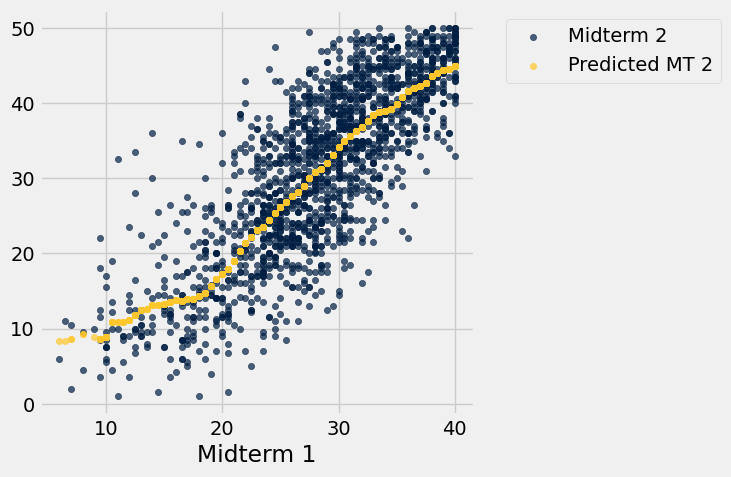

In [13]:
mt1_scores = examples.select('Midterm 1').sort(0, distinct=True)
predictions = mt1_scores.with_column('Predicted MT 2', mt1_scores.apply(predict_mt2, 'Midterm 1'))
t = scores.join('Midterm 1', predictions)
t.drop('Mentored').scatter(0)

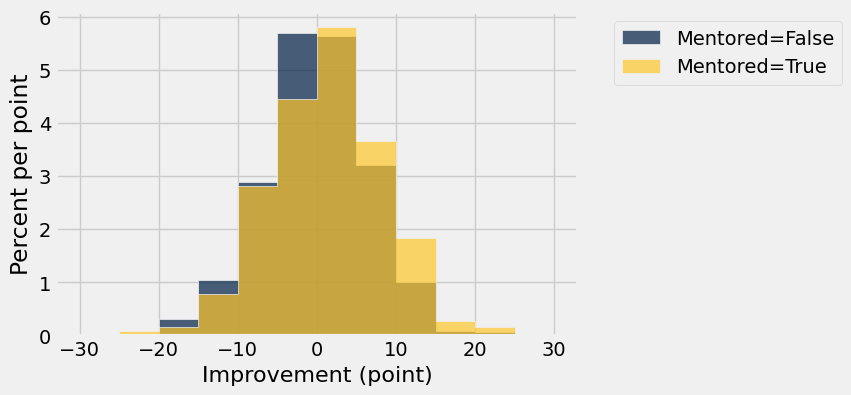

In [14]:
u = t.with_column('Improvement', t.column('Midterm 2') - t.column('Predicted MT 2'))
u.hist('Improvement', bins=np.arange(-30, 31, 5), group='Mentored', unit='point')

In [15]:
def of_at_least_5(values):
    return sum(values >= 5) / len(values)

u.select(2, 4).group('Mentored', of_at_least_5).set_format(1, PercentFormatter)

Mentored,Improvement of_at_least_5
False,21.90%
True,29.63%


In [16]:
u.group('Mentored', np.mean)

Mentored,Midterm 1 mean,Midterm 2 mean,Predicted MT 2 mean,Improvement mean
False,29.3461,32.2821,32.3047,-0.0226162
True,25.5945,28.5629,27.082,1.48083


In [17]:
def mean_ci(observations):
    means = []
    for i in np.arange(2000):
        means.append(observations.sample().column('Improvement').mean())
    print('Mean improvement:', observations.column('Improvement').mean())
    print('95% CI:', percentile(2.5, means), 'to', percentile(97.5, means))
    
mentored = u.where('Mentored', True)
mean_ci(mentored)

Mean improvement: 1.48082915986
95% CI: 0.891219347355 to 2.10224219981
